<h1><font size="+4"><center>
    Casos prácticos de modelado <br/>
    mediante redes neuronales <br/>
    usando TensorFlow<center/></font><h1/>
    
<img src="img/Ecosystem.png" alt="Ecosystem" style="width: 600px;"/>

In [1]:
# increase the cell width of the Jupyter notebook in the browser
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%%html
<iframe src='http://yann.lecun.com/exdb/mnist', width=100%, height=400></iframe>

![MNIST DataBase](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png "MNIST DataBase")

## TensorFlow 2.0

El código que se muestra a continuación está basado en TensorFlow 2.0. Mucho del contenido de este cuaderno está también disponible en la [Guia inicial de TensorFlow 2.0 para principiantes](https://www.tensorflow.org/tutorials/quickstart/beginner).

In [3]:
import tensorflow as tf
tf.__version__

'2.0.0'

## Descarga y análisis de la base de datos

TensorFlow incorpora un sencillo mecanismo para descargar la Base de Datos MNIST:  

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

La base de datos está compuesta por 60.000 muestras de entrenamiento (`x_train`), 10.000 de test (`x_test`) y sus correspondientes etiquetas (`y_train` e `y_test`). Cada muestra representa una imagen de 28x28 píxeles. Las muestras y las etiquetas descargadas están guardadas en arrays n-dimensionales de `numpy`:

In [5]:
for x in (x_train, y_train, x_test, y_test) :
    print(type(x),x.shape)

<class 'numpy.ndarray'> (60000, 28, 28)
<class 'numpy.ndarray'> (60000,)
<class 'numpy.ndarray'> (10000, 28, 28)
<class 'numpy.ndarray'> (10000,)


Mediante el módulo `matplotlib` podemos visualizar el contenido de las primeras 10 muestras de entrenamiento, así como sus respectivas etiquetas:

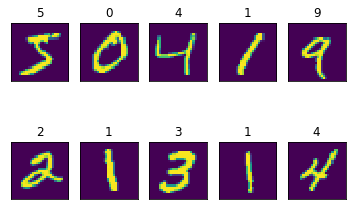

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure()
for i in range(10):  
    plt.subplot(2, 5, i+1)
    plt.title(y_train[i])
    f = plt.imshow(x_train[i])
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
plt.show()

## Adecuación/preparación de los datos

Las imágenes están compuestas por números enteros que representan una escala de grises (`0`: blanco, `255`:negro). El rango real `[0,1]` es mucho más adecuado, por lo que normalizamos los datos:

In [7]:
print(x_train.min(),x_train.max(),x_test.min(),x_test.max())
x_train = x_train / 255
x_test = x_test / 255
print(x_train.min(),x_train.max(),x_test.min(),x_test.max())

0 255 0 255
0.0 1.0 0.0 1.0


Reparticionaremos el conjunto de entrenamiento, reservando el 10% de los datos para validación (monitorización del entrenamiento):

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)

Agruparemos todos los datos en una única variable

In [9]:
from collections import namedtuple

Data = namedtuple('Data', 'input_shape output_categories x_train y_train x_val y_val x_test y_test')
data = Data(x_train.shape[1:], y_train.max()+1, 
            x_train, y_train, 
            x_val, y_val, 
            x_test, y_test)

for name,value in zip(data._fields, data) :
    if name == 'input_shape' or name == 'output_categories':
        print(name,'=',value)
    else :
        print(name,value.shape)

input_shape = (28, 28)
output_categories = 10
x_train (54000, 28, 28)
y_train (54000,)
x_val (6000, 28, 28)
y_val (6000,)
x_test (10000, 28, 28)
y_test (10000,)


## Primer modelo: Regresión Logística Multiclase

Uno de los modelos más sencillos a implementar es una regresión logística multiclase.

<!--
![alt text](img/lr.jpg)
-->

<img src="img/lr.jpg" alt="Global Average Pooling" style="width: 400px;"/>


El modelo se compone de:

   1. `Flatten` : Conversión de las matrices $M$ de entrada de `28x28` en vectores $x$ de `784` componentes.
   1. `Dense` :  Transformación afín $y = A \cdot x + b$ con activación _softmax_ :
   
       &emsp;&emsp;&emsp;&emsp;$z_i = exp(y_i)/\sum_{j}^{ }exp(y_j))$
   


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def LR(data):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=data.input_shape))
    
    model.add(Dense(2, activation='softmax'))
    
    return model

print(data.output_categories)

10


In [11]:
model = LR(data)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1570      
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________


La función de pérdida (`loss`) será la [entropía cruzada](https://es.wikipedia.org/wiki/Entrop%C3%ADa_cruzada), y el optimizados escogido adam ([Adaptive Moment Estimation](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)). Estamos además interesados en observar el índice de acierto, o _accuracy_ :

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Ejecutaremos 5 iteraciones de entrenamiento, observando la evolución de los conjuntos de entrenamiento y validación:


In [13]:
train = model.fit(data.x_train, data.y_train, epochs=5, validation_data = (data.x_val, data.y_val), verbose = 2)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5


InvalidArgumentError:  Received a label value of 9 which is outside the valid range of [0, 2).  Label values: 5 4 8 2 1 9 7 6 2 0 0 0 6 8 1 8 8 1 4 7 8 6 6 8 3 3 4 9 0 8 7 0
	 [[node loss/dense_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_606]

Function call stack:
distributed_function


La variable `train` almacena (entre otras cosas) el historial de la función de coste (`loss`) y la métrica usada (`accuracy`):

In [ ]:
print(train.history['loss'])
print(train.history['val_loss'])
print(train.history['accuracy'])
print(train.history['val_accuracy'])

Finalmente observamos el resultado frente al conjunto de test:

In [ ]:
test = model.evaluate(data.x_test, data.y_test, verbose=0)
print(f'loss: {test[0]:.4f} acc: {test[1]:.4f}')

Podemos representar gráficamente además la evolución de la función objetivo de entrenamiento y validación.

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot(train,test):
    n = len(train.history['loss'])
    x = list(range(1,n+1))
    fig = plt.figure()
    plt.plot(x,train.history['loss'])
    plt.plot(x,train.history['val_loss'])
    plt.plot(x,[test[0]]*n,linestyle=':', linewidth=4)
    plt.title('Training')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val', 'test'], loc='upper right')
    plt.show()
    
plot(train,test)

En base al código anterior, creamos una función que permita simplificar la evaluación de distintos modelos:

In [ ]:
import numpy as np
import tensorflow.keras.backend as K

def evaluate(model, data, optimizer='adam', epochs=10):
    
    model.compile(optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    if len(model.layers) <= 15 :
        model.summary()
    else :
        print(f'Skipping model Summary... it has {len(model.layers)} Layers!')
        tr = np.sum([K.count_params(w) for w in model.trainable_weights])
        ntr = np.sum([K.count_params(w) for w in model.non_trainable_weights])
        print(f'Total params: {tr+ntr}')
        print(f'Trainable params: {tr}')
        print(f'Non-trainable params: {ntr}')       
    
    print('\n----- Train -----')
    train = model.fit(data.x_train, data.y_train,
                        epochs=epochs, validation_data = (data.x_val, data.y_val),
                        verbose = 2)
    print('\n----- Test ------')
    test = model.evaluate(data.x_test,  data.y_test, verbose=0)
    print(f'loss: {test[0]:.4f} acc: {test[1]:.4f}')
    
    plot(train,test)

La evaluación de un modelo LR será:

In [ ]:
model = LR(data)
evaluate(model, data)

## Red neuronal con una capa oculta

![alt text](img/nn.png)

Podemos añadir una capa oculta del tamaño que deseemos...

In [ ]:
def NN(data, hidden, activation='relu'):

    model = Sequential()
    
    model.add(Flatten(input_shape=data.input_shape))
    
    model.add(Dense(hidden, activation=activation))

    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

In [ ]:
evaluate(NN(data, hidden=100), data)

In [ ]:
evaluate(NN(data, hidden=200), data)

In [ ]:
evaluate(NN(data, hidden=300), data)

In [ ]:
evaluate(NN(data, hidden=1000), data)

## DNN - Deep Neural Network

![alt text](img/dnn.png)

Una DNN no es sino una NN conpuesta por múltiples capas ocultas. Podemos añadir tantas capas densas como deseemos...


In [ ]:
def DNN(data, hidden=(), activation='relu'):

    model = Sequential()
    
    model.add(Flatten(input_shape=data.input_shape))

    for h in hidden :
        model.add(Dense(h, activation=activation))
        
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

In [ ]:
model = DNN(data, hidden=(100,100,100,100,100))
evaluate(model, data)

In [ ]:
model = DNN(data, hidden=(1024,1024,1024,1024,1024))
evaluate(model, data)

## Dropout - Evitando el sobreentrenamiento

Se trata de una sencilla y (a veces) efectiva regularización que desconecta aleatoriamente las neuronas durante el entrenamiento.


<!--
![alt text](img/dropout.png)
-->

<img src="img/dropout.png" alt="Global Average Pooling" style="width: 600px;"/>

In [ ]:
from tensorflow.keras.layers import Dropout
    
def DNN(data, hidden=(), activation='relu', dropout=0.2):

    model = Sequential()
    
    model.add(Flatten(input_shape=data.input_shape))

    for h in hidden :
        model.add(Dense(h, activation=activation))
        if dropout :
            model.add(Dropout(dropout))
        
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

In [ ]:
model = DNN(data, hidden=(1024,1024,1024,1024,1024))
evaluate(model, data)

No obstante, a menudo un modelo con menor número de parámetros puede tener un comportamiento más que aceptable

In [ ]:
model = DNN(data, hidden=(128,64,32))
evaluate(model, data)

In [ ]:
model = DNN(data, hidden=(300,))
evaluate(model, data)

## Redes Convolucionales

Una capa convolucional aplica un conjunto de kernels (filtros) que son convolucionados frente a la entrada. El resultado es un `3D-array`. 

![alt text](img/cnn.png)

Para poder usar las capas convolutivas, hay que agregar una dimensión más a los datos.

In [ ]:
# Agrega una dimension de canal
data_conv = Data(
    data.input_shape+(1,), data.output_categories,
    data.x_train[..., tf.newaxis], data.y_train,
    data.x_val[..., tf.newaxis], data.y_val,
    data.x_test[..., tf.newaxis], data.y_test
)
for name,value in zip(data_conv._fields, data_conv) :
    if name == 'input_shape' or name == 'output_categories':
        print(name,'=',value)
    else :
        print(name,value.shape)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

def CNN(data, activation='relu'):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation, input_shape=data.input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

In [ ]:
model = CNN(data_conv)
evaluate(model, data_conv)

## Pero... y el _dropout_ ?

* [Don’t Use Dropout in Convolutional Networks](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html), use BatchNormalization instead.
   * Parece ser que la regularización mediante _dropout_ no es muy adecuada para las CNN
* `BatchNormalization`: Normaliza (**solo** durante el entrenamiento) la media y varianza de los datos de entrada (por batch).

La normalización suele ser aplicada antes de la función de activación, por lo que hay que separar a esta última de la capa de convolución.

In [ ]:
from tensorflow.keras.layers import Activation, BatchNormalization

def CNNbnorm(data, activation='relu'):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=data.input_shape))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

In [ ]:
model = CNNbnorm(data_conv)
evaluate(model, data_conv)

Personalmente... sigue pareciéndome más efectivo el dropout...

In [ ]:
from tensorflow.keras.layers import Conv2D

def CNNdropout(data, activation='relu', dropout=0.2):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation, input_shape=data.input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

In [ ]:
model = CNNdropout(data_conv)
evaluate(model, data_conv)

## Global-average-pooling

Las redes convolucioinales deben terminar en una capa densa con activación _softmax_. La última capa densa debe conectarse a otra capa densa, que normalmente será el resultado de aplanar (`Flatten`) la última capa convolucional. La capa `GlobalAveragePooling2D` realiza un promedio de los canales de la capa convolucional anterior, resultando en un vector cuya dimensión es igual al número de canales. El resultado es una reducción sustancial en el número de parámetros del modelo. 


<!--
![alt text](img/gap.png)
-->

<img src="img/gap.png" alt="Global Average Pooling" style="width: 1200px;"/>

* https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/


 

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

def CNNgap(data, activation='relu',dropout=0.2):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation, input_shape=data.input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
        
    model.add(GlobalAveragePooling2D())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

In [ ]:
model = CNNgap(data_conv)
evaluate(model, data_conv, epochs=20)

## Reproduciendo resultados ajenos

* https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
* https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457

Primero el modelo:

In [ ]:
from tensorflow.keras.optimizers import RMSprop

def XModel(data):

    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape=data.input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

A menudo el parámetro _learning-rate_ suele ser modificado _online_ para adaptarse al entrenamiento. Una estrategia sencilla es reducirlo si la función objetivo no decrece:

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

#reduce the LR by half if the training loss is not improved after 1 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)

Añadimos la reducción del learning-rate a los _callbacks_ del entrenamiento: 

In [ ]:
def evaluate(model, data, optimizer='adam', epochs=10):
    
    model.compile(optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    if len(model.layers) <= 15 :
        model.summary()
    else :
        print(f'Skipping model Summary... it has {len(model.layers)} Layers!')
        tr = np.sum([K.count_params(w) for w in model.trainable_weights])
        ntr = np.sum([K.count_params(w) for w in model.non_trainable_weights])
        print(f'Total params: {tr+ntr}')
        print(f'Trainable params: {tr}')
        print(f'Non-trainable params: {ntr}')        
    
    print('\n----- Train -----')
    train = model.fit(data.x_train, data.y_train,
                        epochs=epochs, validation_data = (data.x_val, data.y_val),
                        verbose = 2, callbacks=[learning_rate_reduction])
    print('\n----- Test ------')
    test = model.evaluate(data.x_test,  data.y_test, verbose=0)
    print(f'loss: {test[0]:.4f} acc: {test[1]:.4f}')
    
    plot(train,test)

Evaluamos el modelo, usando un optimizador _RMSprop_ en vez de _Adam_ (por defecto):

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model = XModel(data_conv)
evaluate(model, data_conv, optimizer=optimizer, epochs=30)

## La Red Residual (Residual Network, ResNet)

 * http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/resnet/resnet.html
 * https://en.wikipedia.org/wiki/Residual_neural_network

Una Red Residual o _ResNet_ contiene conexiones ( _skip connections_ o _shortcuts_ ) que interconectan la salida de una capa con la entrada de una capa no necesariamente contigua, saltando capas intermedias:

<img src="img/ResNet.png" alt="Residual Network" style="width: 200px;"/>

De una manera conceptual, en la fase inicial del entrenamiento la red es guiada por las conexiones cortocircuito, mientras que según avanza el entrenamiento las capas cortocircuitadas comienzan a aportar, compensando a su vez la aportación del cortocircuito.

### Características:

   * Mitiga el problema del _desvanecimiento de gradiente_
   * Acelera el entrenamiento
   * Permite entrenar redes muy profundas (más de 100 capas)

### ResNet identidad

Configuración típica:

   * Capas convolucionales
   * Puente de 2/3 capas
   * El cortocircuito se añade antes de la no linealidad

<img src="img/resnet_identidad.png" alt="resnet identidad" style="width: 400px;"/>

### ResNet convolucional

Configuración típica:

   * Capas convolucionales
   * Puente de 2/3 capas
   * El cortocircuito se añade antes de la no linealidad
   * Las dimensiones no coinciden.
      * Se añade una capa convolucional al cortocircuito
      * No se añade no linealidad

<img src="img/resnet_conv.png" alt="resnet_conv" style="width: 400px;"/>


### RestNet50
<img src="img/resnet50.png" alt="resnet50" style="width: 800px;"/>

### ImageNet Challenge

* Detección de 1000 categorías de objetos en imágenes

|    Red    |  Año | Capas | % Error |
|:---------:|:----:|:-----:|:-------:|
|  AlexNet  | 2013 |   8   |   11.7  |
|    VGG    | 2014 |   19  |   7.3   |
| Inception | 2014 |   22  |   6.7   |
|   ResNet  | 2015 |  152  |   3.6   |


### Implementación de una RestNet
* No es una red secuencial
* No podemos implementarla mediante `tensorflow.keras.models.Sequential`
* TensorFlow permite una descripción *funcional* del modelo
    * Muy similar a lo visto previamente
    * Mayor livertad de diseño

### Logistic Regression - Functional API

Implementación previa (`Sequential`):

```python
def LR(data):    
    model = Sequential()  
    model.add(Flatten(input_shape=data.input_shape))
    model.add(Dense(data.output_categories, activation='softmax'))
    return model
```

Implementación funcional:

In [ ]:
from tensorflow.keras import Input, Model

def LR(data):

    x_input = Input(shape=data.input_shape)

    x = Flatten()(x_input)
    x = Dense(data.output_categories, activation='softmax')(x)
    
    return Model(x_input, x)

In [ ]:
model = LR(data)
evaluate(model, data, epochs=10)

### DNN - Functional API

Implementación previa (`Sequential`):

```python
def DNN(data, hidden=(), activation='relu', dropout=0.2):
    model = Sequential()
    model.add(Flatten(input_shape=data.input_shape))
    for h in hidden :
        model.add(Dense(h, activation=activation))
        if dropout :
            model.add(Dropout(dropout))
    model.add(Dense(data.output_categories, activation='softmax'))
    return model
```

Implementación funcional:

In [ ]:
from tensorflow.keras.layers import Dropout
    
def DNN(data, hidden=(), activation='relu', dropout=0.2):

    x_input = Input(shape=data.input_shape)

    x = Flatten()(x_input)
    for h in hidden :
        x = Dense(h, activation=activation)(x)
        if dropout :
            x = Dropout(dropout)(x)
    x = Dense(data.output_categories, activation='softmax')(x)
    
    return Model(x_input, x)

In [ ]:
model = DNN(data, hidden=(128,64,32))
evaluate(model, data)

### CNN - Functional API

Implementación previa (`Sequential`):

```python
def CNN(data, activation='relu',dropout=0.2):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation, input_shape=data.input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
        
    model.add(GlobalAveragePooling2D())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model
```

Implementación funcional:

In [ ]:
def CNN(data, activation='relu',dropout=0.2):
    
    x_input = Input(shape=data.input_shape)

    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=activation)(x_input)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dropout)(x)
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=activation)(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dropout)(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation=activation)(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dropout)(x)
        
    x = GlobalAveragePooling2D()(x)
    x = Dense(data.output_categories, activation='softmax')(x)
    
    return Model(x_input, x)

In [ ]:
model = CNNgap(data_conv)
evaluate(model, data_conv, epochs=20)

### RestNet - Functional API (no hay otra...)


In [ ]:
from tensorflow.keras.layers import Add

def ResNet(data,n=1):

    x_input = Input(shape=data.input_shape)
    
    x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same')(x_input)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)

    for i in range(n):
        x_id = x
        x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same')(x_input)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, x_id])
        x = Activation(activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)

    for i in range(n):
        x_id = x
        x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, x_id])
        x = Activation(activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

    x = GlobalAveragePooling2D()(x)
    
    x = Dense(data.output_categories, activation = "softmax")(x)    

    return Model(x_input, x)

In [ ]:
model = ResNet(data_conv)
#model.summary()
evaluate(model, data_conv, epochs=20)

In [ ]:
model = ResNet(data_conv,n=10)
evaluate(model, data_conv, epochs=30)

In [ ]:
def ResNet2(data):
    
    x_input = Input(shape=data.input_shape)
    
    x = Conv2D(32, 3, activation='relu')(x_input)
    x = Conv2D(64, 3, activation='relu')(x)
    block_1_output = MaxPool2D(3)(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    block_2_output = Add()([x, block_1_output])

    x = Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    block_3_output = Add()([x, block_2_output])

    x = Conv2D(64, 3, activation='relu')(block_3_output)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)    
    x = Dense(data.output_categories, activation = "softmax")(x)    

    return Model(x_input, x)

In [ ]:
model = ResNet2(data_conv)
evaluate(model, data_conv, epochs=30)